<a href="https://colab.research.google.com/github/nataliepham6720/16-745_Optimal_Control/blob/main/LQR_Riccati.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

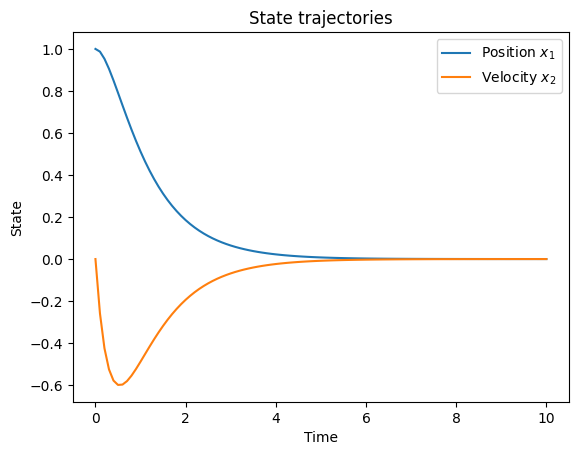

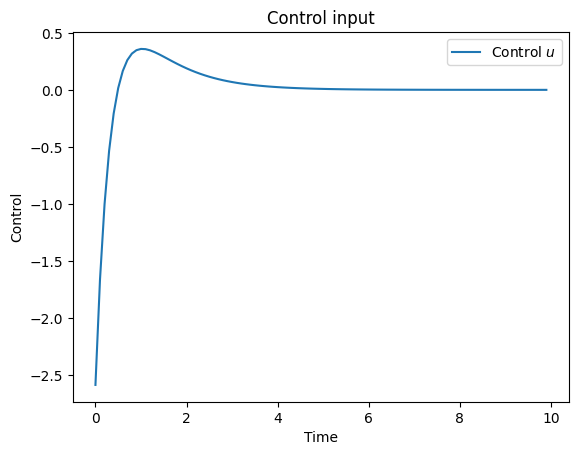

Cost with time-varying K: 6.658612208961309


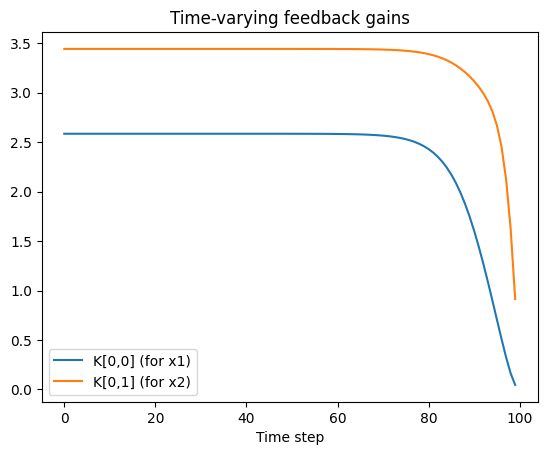

First feedback gain vs infinite-horizon LQR gain:
K[:, :, 0] - Kinf =
 [[-6.72931577e-09 -2.28763852e-09]]
Closed-loop eigenvalues: [0.89917031+0.j 0.7435576 +0.j]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_discrete_are, eigvals

# -------------------------------
# Discrete dynamics
# -------------------------------
h = 0.1
A = np.array([[1, h],
              [0, 1]])
B = np.array([[0.5 * h ** 2],
              [h]])

n = A.shape[0]
m = B.shape[1]
Tfinal = 10.0
N = int(Tfinal / h) + 1
times = np.linspace(0, h * (N - 1), N)

# -------------------------------
# Initial condition
# -------------------------------
x0 = np.array([1.0, 0.0])

# -------------------------------
# Cost matrices
# -------------------------------
Q = np.eye(n)
R = 0.1
Qn = np.eye(n)

# -------------------------------
# Cost function
# -------------------------------
def J(xhist, uhist):
    cost = 0.5 * xhist[:, -1].T @ Qn @ xhist[:, -1]
    for k in range(N - 1):
        cost += 0.5 * xhist[:, k].T @ Q @ xhist[:, k] + 0.5 * R * uhist[:, k] @ uhist[:, k]
    return cost

# -------------------------------
# Backward Riccati recursion
# -------------------------------
P = np.zeros((n, n, N))
K = np.zeros((m, n, N - 1))
P[:, :, -1] = Qn

for k in reversed(range(N - 1)):
    S = R + B.T @ P[:, :, k + 1] @ B
    K[:, :, k] = np.linalg.solve(S, B.T @ P[:, :, k + 1] @ A)
    P[:, :, k] = Q + A.T @ P[:, :, k + 1] @ (A - B @ K[:, :, k])

# -------------------------------
# Forward rollout using feedback gains
# -------------------------------
xhist = np.zeros((n, N))
xhist[:, 0] = x0
uhist = np.zeros((m, N - 1))

for k in range(N - 1):
    uhist[:, k] = -K[:, :, k] @ xhist[:, k]
    xhist[:, k + 1] = A @ xhist[:, k] + B @ uhist[:, k]

# -------------------------------
# Plot state trajectories
# -------------------------------
plt.figure()
plt.plot(times, xhist[0, :], label='Position $x_1$')
plt.plot(times, xhist[1, :], label='Velocity $x_2$')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()
plt.title("State trajectories")

plt.figure()
plt.plot(times[:-1], uhist[0, :], label='Control $u$')
plt.xlabel('Time')
plt.ylabel('Control')
plt.legend()
plt.title("Control input")
plt.show()

print("Cost with time-varying K:", J(xhist, uhist))

# -------------------------------
# Rollout with random noise
# -------------------------------
xhist_noisy = np.zeros((n, N))
xhist_noisy[:, 0] = x0
uhist_noisy = np.zeros((m, N - 1))

for k in range(N - 1):
    uhist_noisy[:, k] = -K[:, :, k] @ xhist_noisy[:, k]
    xhist_noisy[:, k + 1] = A @ xhist_noisy[:, k] + B @ uhist_noisy[:, k] + 0.01 * np.random.randn(n)

# -------------------------------
# Plot K1, K2 (feedback gains over time)
# -------------------------------
plt.figure()
plt.plot(K[0, 0, :], label='K[0,0] (for x1)')
plt.plot(K[0, 1, :], label='K[0,1] (for x2)')
plt.xlabel('Time step')
plt.title("Time-varying feedback gains")
plt.legend()
plt.show()

# -------------------------------
# Infinite-horizon LQR using DARE
# -------------------------------
def dlqr(A, B, Q, R):
    P = solve_discrete_are(A, B, Q, R)
    K = np.linalg.inv(B.T @ P @ B + R) @ (B.T @ P @ A)
    return K, P

Kinf, Pinf = dlqr(A, B, Q, R)
print("First feedback gain vs infinite-horizon LQR gain:")
print("K[:, :, 0] - Kinf =\n", K[:, :, 0] - Kinf)

# -------------------------------
# Rollout with infinite-horizon LQR gain
# -------------------------------
xhist_inf = np.zeros((n, N))
xhist_inf[:, 0] = x0
uhist_inf = np.zeros((m, N - 1))

for k in range(N - 1):
    uhist_inf[:, k] = -Kinf @ xhist_inf[:, k]
    xhist_inf[:, k + 1] = A @ xhist_inf[:, k] + B @ uhist_inf[:, k]

# -------------------------------
# Closed-loop eigenvalues
# -------------------------------
eig_closed_loop = eigvals(A - B @ Kinf)
print("Closed-loop eigenvalues:", eig_closed_loop)
